# Import Data

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# define directory
my_dir = 'images/'
genre = 'noir'

# list images
img_list = os.listdir(my_dir + genre)
print(f"{len(img_list)} images found in {genre} folder.")

3567 images found in noir folder.


Images have the following dimensions: (400, 400)


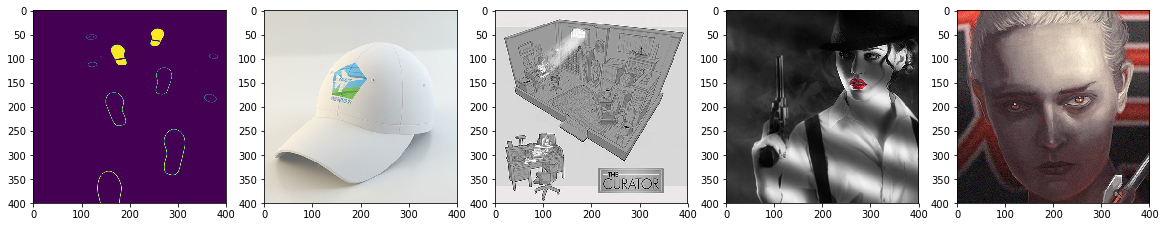

In [21]:
# take a peak at images in full res
plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = mpimg.imread(f"{my_dir}{genre}/{img_list[i]}")
    plt.imshow(img)

img = mpimg.imread(f"{my_dir}{genre}/{img_list[0]}")
print(f"Images have the following dimensions: {img.shape}")
    

# DCGAN - Deep Convolutional GAN

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

A DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution. The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, z, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. In the paper, the authors also give some tips about how to setup the optimizers, how to calculate the loss functions, and how to initialize the model weights, all of which will be explained in the coming sections.

## Setting Up the GAN

In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchsummary import summary

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [63]:
# Root directory for dataset
dataroot = my_dir

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [66]:
def get_target_index(dataset, disp = False):
    '''
    dataset should be ImageFolder class
    '''
    targets = torch.tensor([t[1] for t in dataset.samples])
    idx_dct = {}
    for k,v in dataset.class_to_idx.items():
        idx_dct[k] = (targets == v).nonzero() 
        if disp == True:
            print(f"Class {k} has {len(idx_dct[k])} images.")
    return idx_dct


def create_dataloader(class_name, indices, disp = False):
    '''
    sampler_index should be range of indices for a given class
    '''
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=workers, #shuffle=True, 
         sampler=torch.utils.data.sampler.SubsetRandomSampler(indices)
        )

    if disp == True:
        print(f"{class_name} dataloader has {len(dataloader)} batches.")
        
    return dataloader

def plot_batch(class_name, dataloader):    
    '''
    Plot images from a dataloader
    '''
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{class_name} Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Class cyberpunk has 9859 images.
Class noir has 3567 images.

Batch size is 128.
cyberpunk dataloader has 78 batches.
noir dataloader has 28 batches.


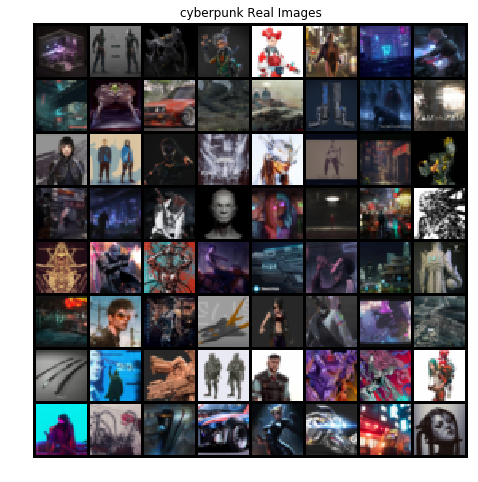

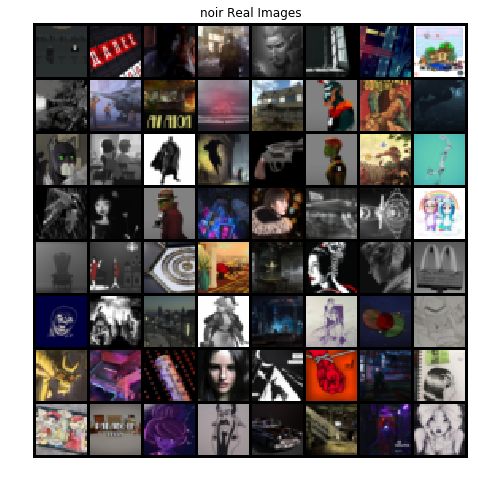

In [69]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

target_idx_dct = get_target_index(dataset, disp=True)

print(f"\nBatch size is {batch_size}.")
cyberpunk_loader = create_dataloader('cyberpunk', target_idx_dct['cyberpunk'], disp = True)
noir_loader = create_dataloader('noir', target_idx_dct['noir'], disp = True)

plot_batch('cyberpunk', cyberpunk_loader)
plot_batch('noir', noir_loader)

## Implementation

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            # nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
summary(netG, (100,1,1))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256,

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            # nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ndf * 8),
            # nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
summary(netD, (3, 32, 32))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,536
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3      

In [11]:
class DCGAN(object):
    
    
    def __init__(self, dataloader, save_dir, num_epochs,
                 criterion, netD, netG, optimizerD, optimizerG,
                 device, fixed_noise):
        
        # data parameters
        self.dataloader = dataloader
        
        # saved checkpoint location
        self.save_dir = save_dir
        
        # model parameters
        self.num_epochs = num_epochs # number of epochs to train for
        self.start_epoch = 1 # the starting epoch
        self.criterion = criterion # loss function
        self.real_label = 1 # Establish convention for real and fake labels during training
        self.fake_label = 0

        # networks init
        self.netD = netD
        self.netG = netG
        self.optimizerD = optimizerD
        self.optimizerG = optimizerG
        
        # device
        self.device = device # specify device being used
        
        # Create batch of latent vectors that we will use to visualize the progression of the generator
        self.fixed_noise = fixed_noise

        
    def train(self):
        
        # Training Loop

        # Lists to keep track of progress
        self.img_list = [] # fake images
        self.G_losses = [] # generator loss
        self.D_losses = [] # discriminator loss
        iters = 0

        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(self.start_epoch, self.start_epoch + self.num_epochs):
            # For each batch in the dataloader
            for i, data in enumerate(self.dataloader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                self.netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(self.device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), self.real_label, device=device)
                # Forward pass real batch through D
                output = self.netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = self.criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                # Generate fake image batch with G
                fake = self.netG(noise)
                label.fill_(self.fake_label)
                # Classify all fake batch with D
                output = self.netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = self.criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                self.optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                self.netG.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = self.netD(fake).view(-1)
                # Calculate G's loss based on this output
                errG = self.criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                self.optimizerG.step()

                # Output training stats
                if i % 50 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                          % (epoch, self.start_epoch + self.num_epochs - 1, i, len(self.dataloader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

                # Save Losses for plotting later
                self.G_losses.append(errG.item())
                self.D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == self.num_epochs-1) and (i == len(self.dataloader)-1)):
                    with torch.no_grad():
                        fake = self.netG(self.fixed_noise).detach().cpu()
                    self.img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
                
            # automatically save model if 20 epochs have passed
            if epoch > 1 and epoch % 20 == 0: self.save(epoch)

        print(f"Finished Training for {epoch} epochs.")
        self.save(epoch)
        

    def save(self, epoch):
        
        # save the model checkpoint
        filepath = f'{self.save_dir}/checkpoint_e{epoch}.pth.tar'
        print(f"=> Saving checkpoint: {filepath}")

        state = {
            'D_losses': self.D_losses,
            'G_losses': self.G_losses,
            'fake_images': self.img_list,
            'epoch': epoch,
            'netD_state_dict': self.netD.state_dict(),
            'optimizerD': self.optimizerD.state_dict(),
            'netG_state_dict': self.netG.state_dict(),
            'optimizerG': self.optimizerG.state_dict(),
        }

        torch.save(state, filepath) 

        
    def load(self, loadpath):
        '''
        When loading model checkpoint, just load the epoch and state dicts to continue training.
        The D-loss, G-loss, and fake images can be stored within their respective checkpoints,
        and referred to later when needed.
        '''
        if os.path.isfile(loadpath):
            print(f"=> loading checkpoint: {loadpath}")
            checkpoint = torch.load(loadpath)

            self.start_epoch = checkpoint['epoch'] + 1
            self.netD.load_state_dict(checkpoint['netD_state_dict'])
            self.netG.load_state_dict(checkpoint['netG_state_dict'])
            self.optimizerD.load_state_dict(checkpoint['optimizerD'])
            self.optimizerG.load_state_dict(checkpoint['optimizerG'])

            print(f"=> loaded checkpoint: {loadpath} (continue with epoch {self.start_epoch})")
            
        else: 
            print(f"=> No checkpoint found at: {loadpath}")
            
            
    def visualize_results(self):
        
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(self.G_losses,label="G")
        plt.plot(self.D_losses,label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
    
    def plot_real_vs_fake(self):
        
        # Grab a batch of real images from the dataloader
        real_batch = next(iter(self.dataloader))

        # Plot the real images
        plt.figure(figsize=(25,25))
        plt.subplot(1,2,1)
        plt.axis("off")
        plt.title("Real Images")
        plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(self.device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

        # Plot the fake images from the last epoch
        plt.subplot(1,2,2)
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(np.transpose(self.img_list[-1],(1,2,0)))
        plt.show()

In [12]:
kwargs = {
    'dataloader': dataloader,
    'save_dir':'checkpoints/noir128-32/',
    'num_epochs': 30,
    'criterion': nn.BCELoss(), # Initialize BCELoss function
    'netD': netD,
    'netG': netG,
    'optimizerD': optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)),
    'optimizerG': optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)),
    'device': device,
    # Create batch of latent vectors that we will use to visualize the progression of the generator
    'fixed_noise': torch.randn(64, nz, 1, 1, device=device) 
    
}
    
dcgan = DCGAN(**kwargs)
dcgan.train()

Starting Training Loop...
[1/30][0/28]	Loss_D: 1.3426	Loss_G: 1.2051	D(x): 0.5270	D(G(z)): 0.4774 / 0.3158
[2/30][0/28]	Loss_D: 0.7694	Loss_G: 2.5493	D(x): 0.7169	D(G(z)): 0.3241 / 0.0843
[3/30][0/28]	Loss_D: 0.2629	Loss_G: 3.4719	D(x): 0.8797	D(G(z)): 0.1168 / 0.0349
[4/30][0/28]	Loss_D: 0.1686	Loss_G: 4.2934	D(x): 0.9408	D(G(z)): 0.0993 / 0.0148
[5/30][0/28]	Loss_D: 0.1113	Loss_G: 4.8127	D(x): 0.9577	D(G(z)): 0.0645 / 0.0086
[6/30][0/28]	Loss_D: 0.1216	Loss_G: 4.0730	D(x): 0.9337	D(G(z)): 0.0461 / 0.0210
[7/30][0/28]	Loss_D: 0.6051	Loss_G: 2.9732	D(x): 0.5898	D(G(z)): 0.0201 / 0.0679
[8/30][0/28]	Loss_D: 0.4085	Loss_G: 3.0065	D(x): 0.8568	D(G(z)): 0.2099 / 0.0602
[9/30][0/28]	Loss_D: 0.9137	Loss_G: 3.2114	D(x): 0.8292	D(G(z)): 0.4761 / 0.0606
[10/30][0/28]	Loss_D: 0.6176	Loss_G: 1.9787	D(x): 0.7763	D(G(z)): 0.2701 / 0.1575
[11/30][0/28]	Loss_D: 1.1456	Loss_G: 1.3668	D(x): 0.4484	D(G(z)): 0.1726 / 0.3018
[12/30][0/28]	Loss_D: 0.4578	Loss_G: 2.1048	D(x): 0.8114	D(G(z)): 0.2032 / 0.1445

In [17]:
dcgan.load('checkpoints/noir128-32//checkpoint_e60.pth.tar')

=> loading checkpoint: checkpoints/noir128-32//checkpoint_e60.pth.tar
=> loaded checkpoint: checkpoints/noir128-32//checkpoint_e60.pth.tar (continue with epoch 61)


In [18]:
dcgan.train()

Starting Training Loop...
[61/90][0/28]	Loss_D: 0.9260	Loss_G: 2.8386	D(x): 0.8068	D(G(z)): 0.4667 / 0.0772
[62/90][0/28]	Loss_D: 1.0139	Loss_G: 1.3896	D(x): 0.4901	D(G(z)): 0.1951 / 0.2925
[63/90][0/28]	Loss_D: 0.8306	Loss_G: 1.5733	D(x): 0.6496	D(G(z)): 0.2902 / 0.2400
[64/90][0/28]	Loss_D: 0.9544	Loss_G: 2.4420	D(x): 0.7386	D(G(z)): 0.4350 / 0.1028
[65/90][0/28]	Loss_D: 0.7858	Loss_G: 1.7211	D(x): 0.6393	D(G(z)): 0.2407 / 0.2134
[66/90][0/28]	Loss_D: 0.7360	Loss_G: 2.1292	D(x): 0.6285	D(G(z)): 0.1871 / 0.1361
[67/90][0/28]	Loss_D: 0.7741	Loss_G: 1.7010	D(x): 0.6500	D(G(z)): 0.2372 / 0.2375
[68/90][0/28]	Loss_D: 0.8088	Loss_G: 1.8055	D(x): 0.6594	D(G(z)): 0.2779 / 0.1902
[69/90][0/28]	Loss_D: 1.0303	Loss_G: 2.2251	D(x): 0.7398	D(G(z)): 0.4750 / 0.1399
[70/90][0/28]	Loss_D: 0.8202	Loss_G: 2.4910	D(x): 0.7112	D(G(z)): 0.3356 / 0.1019
[71/90][0/28]	Loss_D: 0.7904	Loss_G: 1.8261	D(x): 0.6814	D(G(z)): 0.2981 / 0.1922
[72/90][0/28]	Loss_D: 0.8183	Loss_G: 1.6098	D(x): 0.6236	D(G(z)): 0.2521

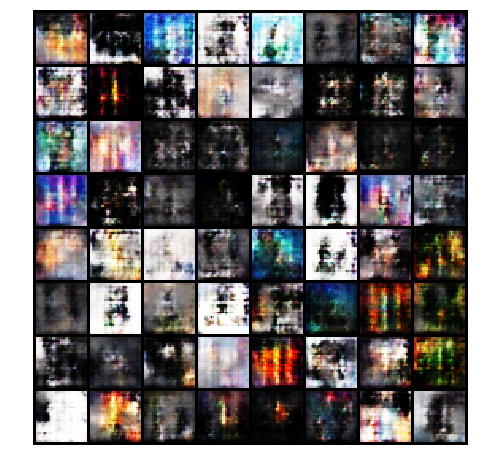

In [19]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in dcgan.img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())